<a href="https://colab.research.google.com/github/tntn245/Extended-MCOKE-PySpark/blob/main/PySpark_MCOKE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT THƯ VIỆN**

In [ ]:
# cai dat PySpark tren Google Colab
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e16fb2b5fda93e2e99e1adc2fa3573a4fd50c7128dd2579dde6b6ba820f5c126
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import json
# import cac thu vien random, ham do nguoi dung tu tao, kieu du lieu Int
import numpy as np
# import thu vien pandas de rang buoc kieu du lieu cua bien dau vao
import pandas as pd
# import cac thu vien ham do nguoi dung tu tao, struct, kieu du lieu Int, Boolean
from pyspark.sql.functions import udf, struct
from pyspark.sql.functions import when
from pyspark.sql.functions import col, expr
from pyspark.sql.types import IntegerType, BooleanType, StringType, MapType, DoubleType
# import cac thu vien de thao tac voi cac dong, cac cot va su dung cac ham trong Pyspark
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row

# import ham reduce
from functools import reduce
# Import thu vien SparkSession
import string
from pyspark.sql.functions import col, lit, sqrt, isnan
from scipy.spatial.distance import cdist

In [ ]:
# Tao Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Kiem tra thong tin Spark Session
spark

# **IMPORT DATASET**

In [ ]:
# import pandas as pd

# # Đọc dữ liệu từ file Excel
# excel_file_path = '/content/DataIncomeOutcome.xlsx'
# df = pd.read_excel(excel_file_path)

# # Lưu dữ liệu sang file CSV
# csv_file_path = '/content/DataIncomeOutcome.csv'
# df.to_csv(csv_file_path, index=False)

# print(f'The Excel file has been successfully converted to CSV: {csv_file_path}')


In [ ]:
csv_file_path = '/content/diamonds.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

dimensions = df.columns
df.show()
print(dimensions)

+----+---+---+---+----+----+---+----+----+----+
|  _1| _2| _3| _4|  _5|  _6| _7|  _8|  _9| _10|
+----+---+---+---+----+----+---+----+----+----+
|0.23|  4|  5|  1|61.5|55.0|326|3.95|3.98|2.43|
|0.21|  3|  5|  2|59.8|61.0|326|3.89|3.84|2.31|
|0.23|  1|  5|  4|56.9|65.0|327|4.05|4.07|2.31|
|0.29|  3|  1|  3|62.4|58.0|334| 4.2|4.23|2.63|
|0.31|  1|  0|  1|63.3|58.0|335|4.34|4.35|2.75|
|0.24|  2|  0|  5|62.8|57.0|336|3.94|3.96|2.48|
|0.24|  2|  1|  6|62.3|57.0|336|3.95|3.98|2.47|
|0.26|  2|  2|  2|61.9|55.0|337|4.07|4.11|2.53|
|0.22|  0|  5|  3|65.1|61.0|337|3.87|3.78|2.49|
|0.23|  2|  2|  4|59.4|61.0|338| 4.0|4.05|2.39|
| 0.3|  1|  0|  2|64.0|55.0|339|4.25|4.28|2.73|
|0.23|  4|  0|  4|62.8|56.0|340|3.93| 3.9|2.46|
|0.22|  3|  4|  2|60.4|61.0|342|3.88|3.84|2.33|
|0.31|  4|  0|  1|62.2|54.0|344|4.35|4.37|2.71|
| 0.2|  3|  5|  1|60.2|62.0|345|3.79|3.75|2.27|
|0.32|  3|  5|  0|60.9|58.0|345|4.38|4.42|2.68|
| 0.3|  4|  1|  1|62.0|54.0|348|4.31|4.34|2.68|
| 0.3|  1|  0|  2|63.4|54.0|351|4.23|4.2

# **INIT**

In [ ]:
# cac tham so dau vao cua chuong trinh
k = 4 # so cum
loop = 500 # so lan lap

In [ ]:
label = list(range(0, k)) # dan nhan cho cac cum

# ham tao cum ban dau bang cach chon ngau nhien k doi tuong tu du lieu
def initCentroids():
  candidateCenters = df.sample(withReplacement=False,fraction = 1/k).limit(k).toPandas()
  candidateCenters.insert(loc=0, column="cluster", value=label) # them cot vao dau cua dataframe
  return pd.DataFrame(candidateCenters)

In [ ]:
# ham tinh trong tam cac cum
def calcCentroids_KMeans(data: DataFrame):
  centroidsDF = df.groupBy(df.cluster).agg(*(F.avg(c).alias(c) for c in dimensions)) # nhom theo tung cum va tinh trung binh cua tung chieu du lieu
  return pd.DataFrame(centroidsDF.toPandas())

In [ ]:
# ham tinh khoang cach Euclidean
def calcEuclideanDistance(row, centroids: pd.DataFrame):
  distances = {} # kieu du lieu dictionary
  for i in range(0, centroids.shape[0]): # voi moi cum
    sum = 0.
    for j in range(0, len(row)): # voi moi chieu du lieu trong mot dong
      sum += (row[j] - centroids.iloc[i][1+j]) ** 2 # 1+j: lay chinh xac tung chieu du lieu, bo qua cot dau tien la "cluster"
    distances[centroids.iloc[i][0]] = sum ** 0.5 # moi cluster di kem voi mot gia tri khoang cach
  return distances

In [ ]:
# ham tinh khoang cach cua tung diem den cac trong tam sau do tra ve cum gan nhat
def updateCluster(row, centroids: pd.DataFrame):
  distances = calcEuclideanDistance(row, centroids)
  return int(min(distances, key=distances.get)) # su dung ham build-in min va sau do phai ep kieu ve integer
udfUpdateCluster = udf(lambda r: updateCluster(r, centroids.value), IntegerType())

In [ ]:
def updateDistances(row, centroids: pd.DataFrame):
  distances = calcEuclideanDistance(row, centroids)
  return json.dumps(distances)

udfUpdateDistances = udf(lambda r: updateDistances(r, centroids.value), StringType())

In [ ]:
def calcDeltaClusters(oldClus, newClus):
  total = 0.
  for r in range(0, oldClus.shape[0]):
    sum = 0.
    for c in range(1, oldClus.shape[1]):
      sum += (oldClus.iloc[r,c] - newClus.iloc[r,c])**2
    total += sum**0.5
  return total

# **MIN-MAX TO INIT CENTROIDS**

In [ ]:
def initCentroid_MinMax_Random():
  candidateCenters = df.sample(withReplacement=False,fraction = 1/k).limit(1).toPandas()
  candidateCenters.insert(loc=0, column="cluster", value=0) # them cot vao dau cua dataframe
  return pd.DataFrame(candidateCenters)

In [ ]:
def initCentroid_MinMax():
  # Tính khoảng cách Euclidean từ các điểm đến gốc tọa độ (0, 0, 0)
  euclidean_columns = [col(col_name)**2 for col_name in dimensions]
  euclidean_distance_expr = expr("sqrt(" + " + ".join(map(lambda x: f"POW({x}, 2)", dimensions)) + ")").alias("distance")
  df_with_distance = df.select("*", euclidean_distance_expr)
  # Tìm ra điểm có khoảng cách ngắn nhất
  min_distance_row = df_with_distance.orderBy(col("distance")).select(*dimensions).first()
  result_df = pd.DataFrame([min_distance_row.asDict()])
  result_df.insert(loc=0, column="cluster", value=0) # them cot vao dau cua dataframe
  return result_df

In [ ]:
# ham tinh khoang cach Euclidean nho nhat tu cac diem du lieu den cum khoi tao
def calcEuclideanMinDistance(row, centroids: pd.DataFrame):
    distances = {}  # kiểu dữ liệu dictionary
    for i in range(0, centroids.shape[0]):  # với mỗi cụm
        sum = 0.
        for j in range(0, len(row)):  # với mỗi chiều dữ liệu trong một dòng
            sum += (row[j] - centroids.iloc[i][1 + j]) ** 2  # 1 + j: lấy chính xác từng chiều dữ liệu, bỏ qua cột đầu tiên là "cluster"
        distances[centroids.iloc[i][0]] = sum ** 0.5  # mỗi cụm đi kèm với một giá trị khoảng cách
    if len(distances) == 1:
        return str(next(iter(distances.values())))
    return str(min(distances.values()))

In [ ]:
# centroids = initCentroid_MinMax_Random()
centroids = initCentroid_MinMax()
print(centroids)

for i in range(0, k-1):  # đã khởi tạo 1 cụm random trước đó
  #Tính mindist từ các điểm đến các cụm
  udfcalcEuclideanMinDistance = udf(lambda r: calcEuclideanMinDistance(r, centroids), StringType())
  df = df.withColumn("distances", udfcalcEuclideanMinDistance(struct([df[x] for x in dimensions])))

  # Tìm ra điểm dữ liệu có distances lớn nhất
  max_distance_row = df.orderBy(col("distances").desc()).select(*dimensions).first()

  # Convert max_distance_row to a dictionary
  # Create a new DataFrame with the max_distance_row
  max_distance_df = pd.DataFrame([max_distance_row.asDict()])

  # Determine the new value for 'cluster'
  new_cluster_value = centroids['cluster'].max() + 1 if not centroids.empty else 0
  max_distance_df['cluster'] = new_cluster_value

  # Concatenate max_distance_df to centroids
  centroids = pd.concat([centroids, max_distance_df], ignore_index=True)

print(centroids)


   cluster    _1  _2  _3  _4    _5    _6   _7    _8    _9   _10
0        0  0.23   4   5   1  61.5  55.0  326  3.95  3.98  2.43
   cluster    _1  _2  _3  _4    _5    _6     _7    _8    _9   _10
0        0  0.23   4   5   1  61.5  55.0    326  3.95  3.98  2.43
1        1  1.27   2   3   5  61.5  58.0  10321  6.90  6.96  4.26
2        2  0.59   2   5   1  60.5  58.0   1325  5.43  5.51  3.31


# **INIT RANDOM CLUSTERS**

In [ ]:
#khoi tao tam cum ban dau
centroids = initCentroids()
print(centroids)

   cluster    _1    _2    _3
0        0  4.34  4.35  2.75
1        1  3.87  3.78  2.49


# **RUN KMeans**

In [ ]:
udfUpdateCluster = udf(lambda r: updateCluster(r, centroids), IntegerType())
udfUpdateDistances = udf(lambda r: updateDistances(r, centroids), StringType())

df = df.withColumn("cluster", udfUpdateCluster(struct([df[x] for x in dimensions])))
df = df.withColumn("distances", udfUpdateDistances(struct([df[x] for x in dimensions])))
df.show()

# lap loop lan
for i in range(0, loop-1): # loop-1 vì ben tren da thuc hien 1 lan roi
  # df = df.withColumn("cluster_old", df["cluster"]) # luu lai gia tri cum cu tinh duoc o buoc truoc
  centroids_old = centroids
  centroids = calcCentroids_KMeans(df) # tinh toan lai trong tam

  udfUpdateCluster = udf(lambda r: updateCluster(r, centroids), IntegerType())
  udfUpdateDistances = udf(lambda r: updateDistances(r, centroids), StringType())

  df = df.withColumn("cluster", udfUpdateCluster(struct([df[x] for x in dimensions]))) # tinh toan va cap nhat cum moi
  df = df.withColumn("distances", udfUpdateDistances(struct([df[x] for x in dimensions]))) # tinh toan va cap nhat dist moi

  delta = calcDeltaClusters(centroids_old, centroids) # tinh tong chenh lech giua tam cu va moi
  if (delta < 0.00001): # neu thay doi la rat nho thi dung
    print("Lần lặp thứ "+str(i))
    break
# hien thi ket qua
print(centroids)
df.show()

+----+---+---+---+----+----+---+----+----+----+--------------------+-------+
|  _1| _2| _3| _4|  _5|  _6| _7|  _8|  _9| _10|           distances|cluster|
+----+---+---+---+----+----+---+----+----+----+--------------------+-------+
|0.23|  4|  5|  1|61.5|55.0|326|3.95|3.98|2.43|{"0.0": 0.0, "1.0...|      0|
|0.21|  3|  5|  2|59.8|61.0|326|3.89|3.84|2.31|{"0.0": 6.3974995...|      0|
|0.23|  1|  5|  4|56.9|65.0|327|4.05|4.07|2.31|{"0.0": 11.840291...|      0|
|0.29|  3|  1|  3|62.4|58.0|334| 4.2|4.23|2.63|{"0.0": 9.7456964...|      0|
|0.31|  1|  0|  1|63.3|58.0|335|4.34|4.35|2.75|{"0.0": 11.297690...|      0|
|0.24|  2|  0|  5|62.8|57.0|336|3.94|3.96|2.48|{"0.0": 12.275711...|      0|
|0.24|  2|  1|  6|62.3|57.0|336|3.95|3.98|2.47|{"0.0": 12.232812...|      0|
|0.26|  2|  2|  2|61.9|55.0|337|4.07|4.11|2.53|{"0.0": 11.627648...|      0|
|0.22|  0|  5|  3|65.1|61.0|337|3.87|3.78|2.49|{"0.0": 13.784415...|      0|
|0.23|  2|  2|  4|59.4|61.0|338| 4.0|4.05|2.39|{"0.0": 14.367289...|      0|

In [ ]:
# Tạo một cột mới để trích xuất giá trị "0.0" từ cột distances
label_str = [str(x) + '.0' for x in label]
for index, x in enumerate(label_str):
  df = df.withColumn("distcluster_"+str(index), F.regexp_extract("distances", r'"' + x + '":\s*([0-9.]+)', 1).cast("float"))

# Tìm maxdist cho mỗi cluster
maxdist_values = []

for x in label:
  filtered_data = df.filter(df['cluster'] == x)
  maxdist_value = filtered_data.agg(F.max("distcluster_"+str(x)).alias("maxdist_for_cluster_"+str(x))).collect()[0][0]
  maxdist_values.append((x, maxdist_value))

# Tạo DataFrame từ danh sách maxdist_values
schema = ["cluster", "maxdist_value"]
maxdist_df = spark.createDataFrame(maxdist_values, schema=schema)

# Tạo DataFrame từ dữ liệu của centroids
# centroids_df = spark.createDataFrame(centroids, ["cluster", "_1", "_2", "_3", "_4"])
centroids_df = spark.createDataFrame(centroids,["cluster"] + dimensions)

# Thêm cột maxdist_value vào centroids_df từ maxdist_df
centroids_with_maxdist = centroids_df.join(maxdist_df, on="cluster")

# Gán lại biến centroids broadcast từ centroids_with_maxdist DataFrame
# centroids = spark.sparkContext.broadcast(centroids_with_maxdist.toPandas())
# print(centroids.value)
centroids = (centroids_with_maxdist.toPandas())
print(centroids)
df.show()

In [ ]:
for i in range(0, k):
  number_obj = df.filter(col("cluster") == i).count()
  print(number_obj)
print(centroids)

# **RUN OKM**

In [ ]:
k_columns = [col(f"distcluster_{i}") for i in range(k)]
OKM_df = df.select(*dimensions, *k_columns)
# centroids_data = centroids.value

for i in range(0, k):
  # Lấy ra maxdist_value của từng cluster
  cluster_i_maxdist = centroids[centroids['cluster'] == i]['maxdist_value'].values[0]
  # Thêm cột cluster_i vào DataFrame df
  OKM_df = OKM_df.withColumn("cluster_"+str(i), F.when(OKM_df['distcluster_'+str(i)] <= cluster_i_maxdist, 1).otherwise(0))

OKM_df.show()

In [ ]:
for i in range(0, k):
  number_obj = OKM_df.filter(col("cluster_"+str(i)) == 1).count()
  print(number_obj)
print(centroids)

# **Test tính lại tâm cụm đã Overlap & loop như kmeans (chất lượng phân cụm thấp)**

In [ ]:
def calcCentroids_OKM(group_by_column, index):
    centroidsDF = OKM_df.filter(col(group_by_column) == 1).agg(*(F.avg(c).alias(c) for c in dimensions))
    centroids_pd_df = centroidsDF.toPandas()

    # Thêm cột "cluster" với giá trị là biến index
    centroids_pd_df.insert(0, 'cluster', index)

    return pd.DataFrame(centroids_pd_df)

In [ ]:
centroids_old = centroids

for i in range(0, loop):
  print("Lần lặp thứ "+str(i))

  # tính lại tâm sau overlap
  overlapped_centroids_arr = []

  # Lặp qua từng cụm (cluster)
  for i in range(0, k):
      # Tính toán lại tâm cụm sau Overlap
      centroidsDF_i = calcCentroids_OKM("cluster_" + str(i), i)
      overlapped_centroids_arr.append(centroidsDF_i)

  # Gộp các DataFrame kết quả lại thành một DataFrame duy nhất
  overlapped_centroids = pd.concat(overlapped_centroids_arr, ignore_index=True)
  overlapped_centroids = pd.DataFrame(overlapped_centroids)
  # Thêm cột "cluster" với giá trị tăng dần từ 0
  # overlapped_centroids.insert(0, 'cluster', range(len(overlapped_centroids)))

  # tính lại distance từng điểm dữ liệu đến new centroids
  udfUpdateDistances = udf(lambda r: updateDistances(r, overlapped_centroids), StringType())
  OKM_df = OKM_df.withColumn("distances", udfUpdateDistances(struct([OKM_df[x] for x in dimensions])))

  # Tạo một cột mới để trích xuất giá trị "0.0" từ cột distances
  for index, x in enumerate(label_str):
    OKM_df = OKM_df.withColumn("distcluster_"+str(index), F.regexp_extract("distances", r'"' + x + '":\s*([0-9.]+)', 1).cast("float"))

  # Tìm maxdist cho mỗi cluster
  maxdist_values = []

  for x in label:
    filtered_data = OKM_df.filter(OKM_df['cluster_'+str(x)] == 1)
    maxdist_value = filtered_data.agg(F.max("distcluster_"+str(x)).alias("maxdist_for_cluster_"+str(x))).collect()[0][0]
    maxdist_values.append((x, maxdist_value))

  # Tạo DataFrame từ danh sách maxdist_values
  schema = ["cluster", "maxdist_value"]
  maxdist_df = spark.createDataFrame(maxdist_values, schema=schema)

  # Tạo DataFrame từ dữ liệu của centroids
  centroids_df = spark.createDataFrame(overlapped_centroids, ["cluster", "_1", "_2", "_3"])

  # Thêm cột maxdist_value vào centroids_df từ maxdist_df
  centroids_with_maxdist = centroids_df.join(maxdist_df, on="cluster")

  # Gán lại biến centroids broadcast từ centroids_with_maxdist DataFrame
  centroids = (centroids_with_maxdist.toPandas())
  print(centroids)

  # loop points: nếu dist < maxdist => gán vào cluster đó
  for i in range(0, k):
    # Lấy ra maxdist_value của từng cluster
    cluster_i_maxdist = centroids[centroids['cluster'] == i]['maxdist_value'].values[0]
    # Thêm cột cluster_i vào DataFrame df
    OKM_df = OKM_df.withColumn("cluster_"+str(i), F.when(OKM_df['distcluster_'+str(i)] <= cluster_i_maxdist, 1).otherwise(0))

  # Chênh lệch tâm
  delta = calcDeltaClusters(centroids_old, centroids) # tinh tong chenh lech giua tam cu va moi
  centroids_old = centroids
  if (delta < 0.00001): # neu thay doi la rat nho thi dung
    break

OKM_df.show()

Lần lặp thứ 0
   cluster        _1        _2        _3  maxdist_value
0        0  4.890000  3.290000  1.455000       1.075279
1        1  7.300000  3.156250  6.162500       1.006638
2        2  5.794231  2.711538  4.311538       1.498946
3        3  5.084091  3.486364  1.484091       1.101966
4        4  6.337097  2.930645  5.050000       1.019951
Lần lặp thứ 1
   cluster        _1        _2        _3  maxdist_value
0        0  4.963830  3.368085  1.470213       1.176825
1        1  7.161905  3.104762  6.033333       1.138175
2        2  6.015584  2.796104  4.575325       1.845974
3        3  5.016327  3.440816  1.467347       1.178350
4        4  6.330159  2.931746  5.036508       1.031910
Lần lặp thứ 2
   cluster        _1        _2        _3  maxdist_value
0        0  4.991837  3.397959  1.463265       1.214114
1        1  6.900000  3.073529  5.800000       1.440219
2        2  6.120000  2.841111  4.741111       2.046515
3        3  5.016327  3.440816  1.467347       1.178350
4     

In [ ]:
for i in range(0, k):
  number_obj = OKM_df.filter(col("cluster_"+str(i)) == 1).count()
  print(number_obj)

44
81
72
40


# **PLOT**

In [ ]:
res = df.toPandas()
res

res_OKM = OKM_df.toPandas()
res_OKM

,_1,_2,_3,distcluster_0,distcluster_1,cluster_0,cluster_1
0,3.95,3.98,2.43,5.607643,2.736224,1,1
1,3.89,3.84,2.31,5.435380,2.914799,1,1
2,4.05,4.07,2.31,5.679120,2.667076,1,1
3,4.20,4.23,2.63,6.011148,2.332292,0,1
4,4.34,4.35,2.75,6.229455,2.116493,0,1
...,...,...,...,...,...,...,...
53935,5.75,5.76,3.50,8.345181,0.049773,0,1
53936,5.69,5.75,3.61,8.345011,0.083585,0,1
53937,5.66,5.68,3.56,8.261716,0.093103,0,1
53938,6.15,6.12,3.74,8.934240,0.602532,0,1


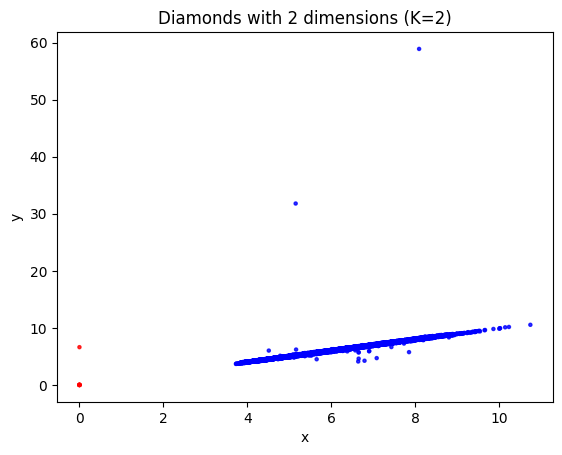

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Đặt tên cho trục x và y
plt.xlabel('x')
plt.ylabel('y')

# Đặt tiêu đề cho biểu đồ
plt.title('Diamonds with 2 dimensions (K=2)')

# Chọn màu sắc theo mong muốn
colors = ['red', 'blue']  # Thay đổi màu sắc theo số lượng cluster hoặc yêu cầu của bạn
cmap = ListedColormap(colors)

plt.scatter(res['_1'], res['_2'], c=res['cluster'], alpha=0.8, s=5, cmap=cmap)

# Hiển thị biểu đồ
plt.show()


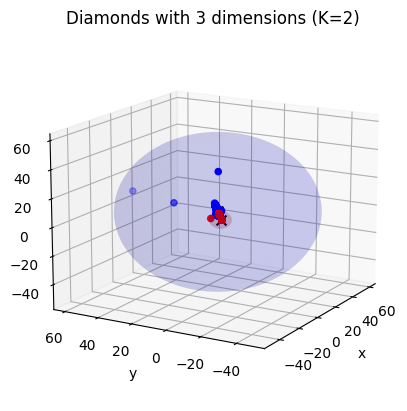

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.patches import Circle

# Tạo biểu đồ 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r' if c0 == 1 else 'b' if c1 == 1 else 'g' for c0, c1 in zip(res_OKM['cluster_0'], res_OKM['cluster_1'])]
colors_R = ['r', 'b', 'g']

# Vẽ điểm 3D
ax.scatter(res_OKM['_1'], res_OKM['_2'], res_OKM['_3'], c=colors, marker='o')

# # Vẽ điểm 3D cho từng cluster
# for index, row in centroids.iterrows():
#     ax.scatter(row['_1'], row['_2'], row['_3'], marker='x', s=50, label=f'Cluster {row["cluster"]}')

# Vẽ vòng tròn cho từng cluster dựa trên bán kính maxdist_value
for index, (row, color, colors_R) in enumerate(zip(centroids.iterrows(), colors, colors_R)):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = row[1]['maxdist_value'] * np.outer(np.cos(u), np.sin(v)) + row[1]['_1']
    y = row[1]['maxdist_value'] * np.outer(np.sin(u), np.sin(v)) + row[1]['_2']
    z = row[1]['maxdist_value'] * np.outer(np.ones(np.size(u)), np.cos(v)) + row[1]['_3']
    ax.plot_surface(x, y, z, color=colors_R, alpha=0.1)

# Vẽ điểm centroids 3D với dấu "x"
for index, row in centroids.iterrows():
    ax.scatter(row['_1'], row['_2'], row['_3'], marker='x', s=50, c='black', label=f'Cluster {row["cluster"]}')

# Đặt tên cho trục
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=15, azim=-150)
ax.set_title('Diamonds with 3 dimensions (K=2)')



plt.show()


# **TÍNH GIÁ TRỊ DBI**

In [ ]:
# DBI của MCOKE*
sum = 0.0
for i in range(0,k):
  max = 0.0
  for j in range(0,k):
    if(i!=j):
      average_i =  OKM_df.filter(col("cluster_"+str(i)) == 1).agg({"distcluster_"+str(i): "avg"}).collect()[0][0]
      average_j =  OKM_df.filter(col("cluster_"+str(j)) == 1).agg({"distcluster_"+str(j): "avg"}).collect()[0][0]

      # Lấy các giá trị của centroid cho cluster 0 và cluster 1
      centroid_i = centroids.loc[centroids['cluster'] == i, dimensions].values
      centroid_j = centroids.loc[centroids['cluster'] == j, dimensions].values
      # Tính khoảng cách Euclidean giữa hai điểm
      distance_centroids = np.linalg.norm(centroid_i - centroid_j)

      res = (average_i + average_j)/distance_centroids
      max = res if res > max else max
  sum += max

DB= 1/k * sum
print(DB)

0.41507723728113577


In [ ]:
# DBI của KMeans
from pyspark.sql.functions import col
sum = 0.0
for i in range(0,k):
  max = 0.0
  for j in range(0,k):
    if(i!=j):
      average_i =  df.filter(col("cluster") == i).agg({"distcluster_"+str(i): "avg"}).collect()[0][0]
      average_j =  df.filter(col("cluster") == j).agg({"distcluster_"+str(j): "avg"}).collect()[0][0]

      # Lấy các giá trị của centroid cho cluster 0 và cluster 1
      centroid_i = centroids.loc[centroids['cluster'] == i, dimensions].values
      centroid_j = centroids.loc[centroids['cluster'] == j, dimensions].values

      # Tính khoảng cách Euclidean giữa hai điểm
      distance_centroids = np.linalg.norm(centroid_i - centroid_j)

      res = (average_i + average_j)/distance_centroids
      max = res if res > max else max
  sum += max

DB= 1/k * sum
print(DB)

0.4048341365631614


# **Biểu đồ so sánh DBI**

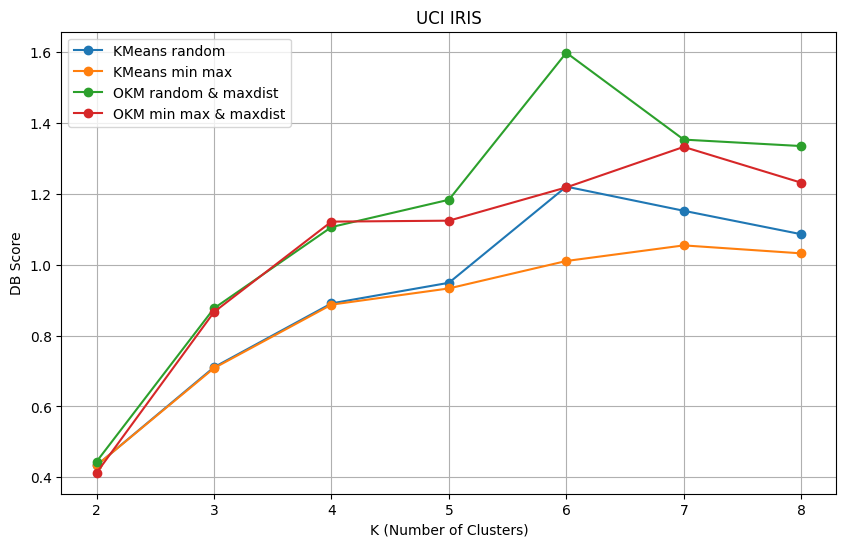

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu của bạn
data = {
    'K': [2, 3, 4, 5, 6, 7, 8],
    'KMeans random': [0.43363600476929015, 0.7108441360126143, 0.8910060570482814, 0.9491998563914769, 1.2206291724931826, 1.1524676524031223, 1.0863071737233303],
    'KMeans min max': [0.43363600476929015, 0.7083492349631177, 0.8875064494270568, 0.9332899964169663, 1.010722781245553, 1.0547587174360324, 1.0322605380329966],
    'OKM random & maxdist': [0.44460784945981024, 0.8772109975023576, 1.1065029685459227, 1.1836248013758006, 1.5986621830557808, 1.3533793115871822, 1.3351886914540907],
    'OKM min max & maxdist': [0.4130045624726405, 0.8667570150291986, 1.1218644487553997, 1.1245408060246103, 1.2185219151343871, 1.3328420495028344, 1.2317960539326447]
}

# Chuyển đổi dữ liệu thành DataFrame để vẽ biểu đồ
import pandas as pd
df = pd.DataFrame(data)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ đường cho KMeans random
plt.plot(df['K'], df['KMeans random'], marker='o', label='KMeans random')

# Vẽ đường cho KMeans min max
plt.plot(df['K'], df['KMeans min max'], marker='o', label='KMeans min max')

# Vẽ đường cho OKM random & maxdist
plt.plot(df['K'], df['OKM random & maxdist'], marker='o', label='OKM random & maxdist')

# Vẽ đường cho OKM min max & maxdist
plt.plot(df['K'], df['OKM min max & maxdist'], marker='o', label='OKM min max & maxdist')

# Đặt tên cho trục x và trục y, thêm tiêu đề
plt.xlabel('K (Number of Clusters)')
plt.ylabel('DB Score')
plt.title('UCI IRIS')
plt.legend()  # Hiển thị chú thích

# Hiển thị biểu đồ
plt.grid(True)
plt.show()


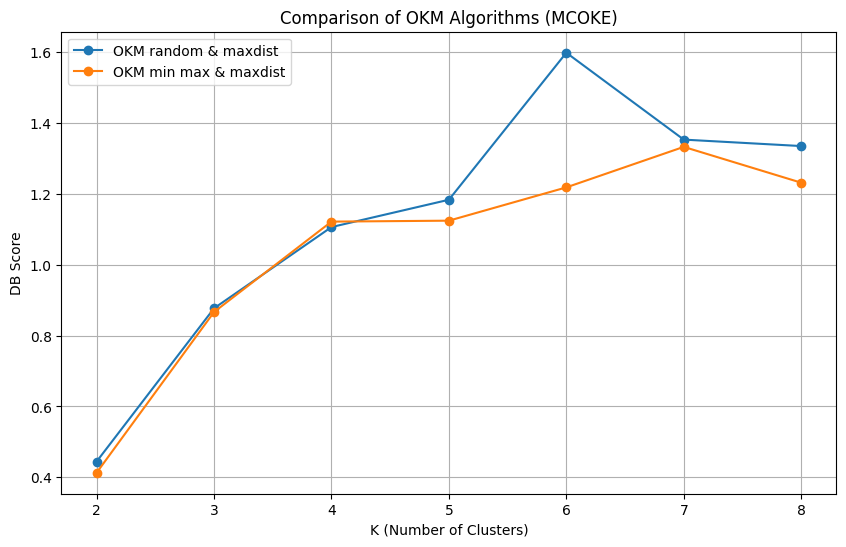

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu của bạn
data = {
    'K': [2, 3, 4, 5, 6, 7, 8],
    'OKM random & maxdist': [0.44460784945981024, 0.8772109975023576, 1.1065029685459227, 1.1836248013758006, 1.5986621830557808, 1.3533793115871822, 1.3351886914540907],
    'OKM min max & maxdist': [0.4130045624726405, 0.8667570150291986, 1.1218644487553997, 1.1245408060246103, 1.2185219151343871, 1.3328420495028344, 1.2317960539326447]
}

# Chuyển đổi dữ liệu thành DataFrame để vẽ biểu đồ
import pandas as pd
df = pd.DataFrame(data)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ đường cho OKM random & maxdist
plt.plot(df['K'], df['OKM random & maxdist'], marker='o', label='OKM random & maxdist')

# Vẽ đường cho OKM min max & maxdist
plt.plot(df['K'], df['OKM min max & maxdist'], marker='o', label='OKM min max & maxdist')

# Đặt tên cho trục x và trục y, thêm tiêu đề
plt.xlabel('K (Number of Clusters)')
plt.ylabel('DB Score')
plt.title('Comparison of OKM Algorithms (MCOKE)')
plt.legend()  # Hiển thị chú thích

# Hiển thị biểu đồ
plt.grid(True)
plt.show()


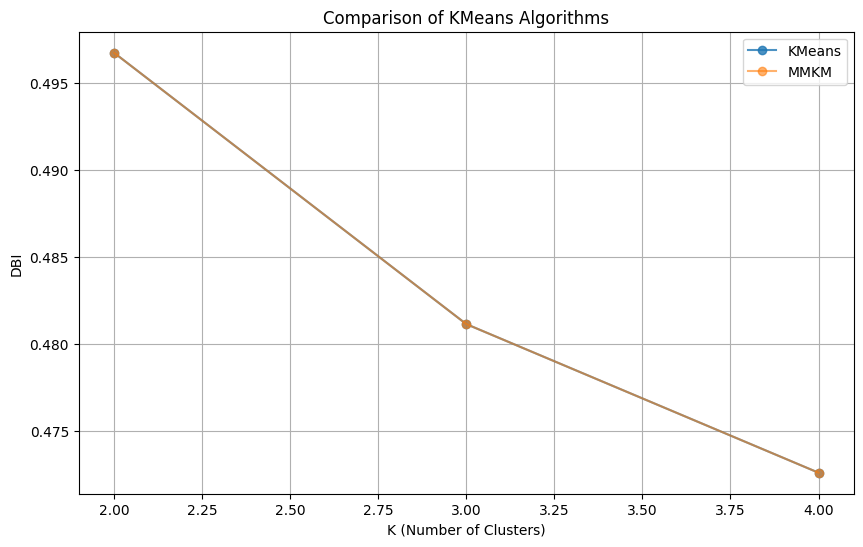

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu của bạn
k_values = [2, 3, 4]
kmeans_values = [0.49671756817876844, 0.4811461819781067, 0.4726171176848102]
mmkmeans_values = [0.49671756817876844, 0.4811461819781067, 0.4726171176848102]
mcoke_values = [0.7162878178046823, 0.6391919664472856, 0.5718299600408736]
mcoke_star_values = [0.7162878178046823, 0.6391919664472857, 0.5718299600408736]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(k_values, kmeans_values, marker='o', label='KMeans', alpha=0.8)
plt.plot(k_values, mmkmeans_values, marker='o', label='MMKM', alpha=0.6)
# plt.plot(k_values, mcoke_values, marker='o', label='MCOKE', alpha=0.6)
# plt.plot(k_values, mcoke_star_values, marker='o', label='MCOKE*', alpha=0.6)

plt.title('Comparison of OKM Algorithms (MCOKE)')
plt.title('Comparison of KMeans Algorithms')
# plt.title('Comparison based on Diamonds with 10 attributes')


plt.xlabel('K (Number of Clusters)')
plt.ylabel('DBI')

plt.legend()
plt.grid(True)
plt.show()
